In [1]:
import os
from utils import DataSeq, load_ids

import numpy as np
import pandas as pd
import skimage.io as io

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

import keras_tuner as kt

from imblearn.over_sampling import RandomOverSampler

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

2023-08-31 09:04:24.086050: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-31 09:04:24.270138: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 09:04:25.184689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
path = "./Train_non_experts_simple/"
batch_size = 8
epochs = 10

In [3]:
ids, labels = load_ids(path)
print(ids.shape, labels.shape)
X_train, X_valid, y_train, y_valid = train_test_split(ids, labels, test_size=0.2, random_state=42)

2023-08-31 09:04:28.948700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


(75243,) (75243, 3)


2023-08-31 09:04:29.057166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-31 09:04:29.057215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-31 09:04:29.060064: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-31 09:04:29.060107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-31 09:04:29.060131: I tensorflow/compile

# Oversampling the data

In [4]:
over_sampler = RandomOverSampler()
X_train_over, y_train_over = over_sampler.fit_resample(X_train.reshape(-1, 1), y_train)
X_train_over = X_train_over.flatten()

# Check if labels are correct
all_equal = True
for i in range(100):
    # Compare path label vs y_train_over label
    if np.argmax(y_train_over[i]) != int(X_train_over[i][27]) - 1:
        all_equal = False

print(all_equal)

True


In [5]:
values, counts = np.unique(np.argmax(y_train,axis=1), return_counts = True)
print("Training labels BEFORE oversampling")

for val, count in zip(values, counts):
    print(val, count)

y = np.argmax(y_train_over,axis=1)
values, counts = np.unique(y, return_counts = True)
print("\nTraining labels AFTER oversampling")

for val, count in zip(values, counts):
    print(val, count)

Training labels BEFORE oversampling
0 29793
1 22193
2 8208

Training labels AFTER oversampling
0 29793
1 29793
2 29793


In [6]:
train_seq = DataSeq(X_train_over, y_train_over)
valid_seq = DataSeq(X_valid, y_valid)

train_steps = len(X_train_over) // batch_size
valid_steps = len(X_valid) // batch_size

# Hyperparameter Tuning

In [7]:
 def build_transfer_vgg_aug(hp):
    input_layer = Input(shape=(224, 224, 3))

    data_augmentation = tf.keras.Sequential([
        input_layer,
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.15),
    ])
    
    vgg = tf.keras.applications.VGG16(weights=None, include_top=False, input_tensor=data_augmentation.output)
    vgg.load_weights('./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    vgg.trainable = False

    model = vgg.output
    model = Flatten()(model)

    neurons = hp.Choice("neurons", [1024, 2048, 4096])
    layers = hp.Choice("layers", [1, 2, 3])

    for i in range(layers):
        model = Dense(neurons, activation='relu')(model)
        model = Dropout(0.25)(model)

    model = Dense(3, activation='softmax')(model)

    model = Model(input_layer, model, name="Transfer_VGG16")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [20]:
obj = kt.Objective("val_accuracy", "max")
tuner = kt.Hyperband(build_transfer_vgg_aug,
                     objective=obj,
                     max_epochs=20,
                     factor=3,
                     seed = 42,
                     directory='./tuner_results/',
                     project_name='hyperband')

# tuner = kt.RandomSearch(
#     hypermodel=build_transfer_vgg_aug,
#     objective=obj,
#     max_trials=3,
#     executions_per_trial=1,
#     overwrite=True,
#     directory='./tuner_results/',
#     project_name='BCSS',
# )

tuner.search_space_summary()

Search space summary
Default search space size: 2
neurons (Choice)
{'default': 1024, 'conditions': [], 'values': [1024, 2048, 4096], 'ordered': True}
layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}


In [22]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(train_seq, validation_data=valid_seq, steps_per_epoch=train_steps,
   validation_steps=valid_steps, epochs=20, callbacks=[stop_early])

Trial 9 Complete [00h 25m 57s]
val_accuracy: 0.8328016996383667

Best val_accuracy So Far: 0.8434343338012695
Total elapsed time: 04h 18m 12s
INFO:tensorflow:Oracle triggered exit


In [23]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Optimal number of neurons per layer is {best_hps.get('neurons')}")
print(f"Optimal number of layers is {best_hps.get('layers')}")

Optimal number of neurons per layer is 4096
Optimal number of layers is 1


In [24]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "Transfer_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                    

In [25]:
tuner.results_summary()

Results summary
Results in ./tuner_results/hyperband
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0002 summary
Hyperparameters:
neurons: 4096
layers: 1
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8434343338012695

Trial 0005 summary
Hyperparameters:
neurons: 1024
layers: 1
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8389154672622681

Trial 0003 summary
Hyperparameters:
neurons: 1024
layers: 2
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8361908793449402

Trial 0008 summary
Hyperparameters:
neurons: 1024
layers: 3
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8328016996383667

Trial 0006 summary
Hyperparameters:
neurons: 4096
layers: 3
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8325358629226685

Trial 0000 summary
Hyperparameters:
neurons: 2048
layers: 1
tuner/epochs: 3
tuner/ini

In [26]:
history = model.fit(train_seq, validation_data=valid_seq, steps_per_epoch=train_steps,
 validation_steps=valid_steps, epochs=10, callbacks=[stop_early])

Epoch 1/10
11172/11172 [==============================] - 608s 54ms/step - loss: 0.5476 - accuracy: 0.7998 - val_loss: 0.4067 - val_accuracy: 0.8364
Epoch 2/10
11172/11172 [==============================] - 605s 54ms/step - loss: 0.4547 - accuracy: 0.8197 - val_loss: 0.4056 - val_accuracy: 0.8357
Epoch 3/10
11172/11172 [==============================] - 605s 54ms/step - loss: 0.4408 - accuracy: 0.8232 - val_loss: 0.3969 - val_accuracy: 0.8366
Epoch 4/10
11172/11172 [==============================] - 606s 54ms/step - loss: 0.4334 - accuracy: 0.8280 - val_loss: 0.4922 - val_accuracy: 0.7794
Epoch 5/10
11172/11172 [==============================] - 605s 54ms/step - loss: 0.4274 - accuracy: 0.8289 - val_loss: 0.4033 - val_accuracy: 0.8277
Epoch 6/10
11172/11172 [==============================] - 605s 54ms/step - loss: 0.4241 - accuracy: 0.8317 - val_loss: 0.4151 - val_accuracy: 0.8244


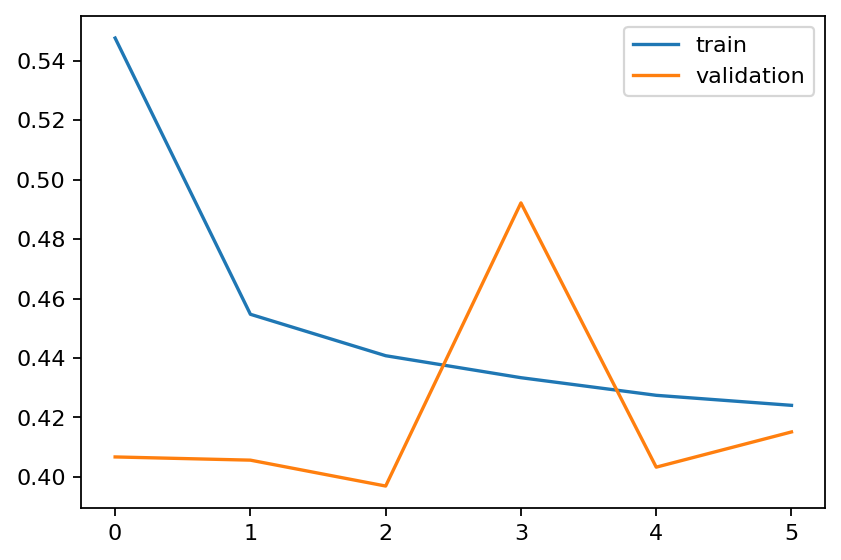

In [30]:
plt.figure(figsize=(6, 4), dpi=160)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.show()

In [31]:
test_path = "./Test/"
test_ids, test_labels = load_ids(test_path)
test_seq = DataSeq(test_ids, test_labels)

In [32]:
y_pred = model.predict(test_seq)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(np.argmax(test_labels, axis=1), y_pred))


546/546 [==============================] - 18s 33ms/step
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      2692
           1       0.74      0.75      0.74      1196
           2       0.62      0.91      0.74       476

    accuracy                           0.82      4364
   macro avg       0.76      0.83      0.78      4364
weighted avg       0.83      0.82      0.82      4364



In [33]:
 model.save_weights('./bcss_aug_weights.h5')